In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.optimize import differential_evolution

from joblib import Parallel, delayed
from tqdm import tqdm

In [14]:
np.random.seed(42)
plt.style.use('ggplot')

In [15]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(1)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684


In [17]:
theta = 30
phi = 10

X0 = 0
Y0 = 0
Z0 = -18

s = 1.3
Ne = 1.1e7

In [18]:
def compute_r(X0, Y0, Z0, theta, phi, coordinates_df):
    theta = np.radians(theta)
    phi = np.radians(phi)

    v = np.array([np.cos(phi) * np.sin(theta), np.sin(phi)
                 * np.sin(theta), np.cos(theta)])

    P0 = np.array([X0, Y0, Z0])

    P = np.vstack(
        (coordinates_df['X'], coordinates_df['Y'], coordinates_df['Z'])).T

    cross_product = np.cross(P - P0, v)

    r = np.linalg.norm(cross_product, axis=1) / np.linalg.norm(v)

    return r

In [19]:
def rho_model(r, Ne, s, r_m=78):
    term1 = Ne / (2 * np.pi * r_m**2)
    term2 = (r / r_m) ** (s - 2)
    term3 = (1 + r / r_m) ** (s - 4.5)
    term4 = gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return term1 * term2 * term3 * term4

In [20]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((rho_calc - rho) ** 2)

In [21]:
r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)

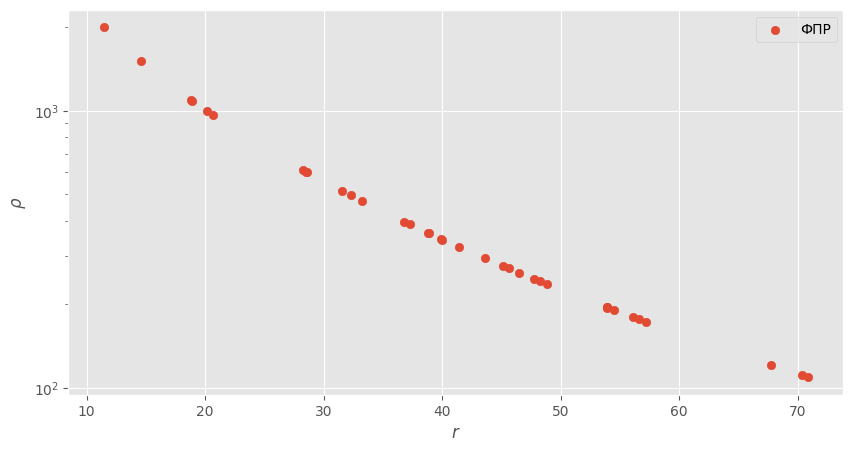

In [22]:
rho = rho_model(r, Ne, s)

plt.figure(figsize=(10, 5))
plt.scatter(r, rho, label="ФПР")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

In [52]:
# Начальные приближения параметров
initial_params = [2.37,  -1.91,  8498223, 1.3297]  # X0, Y0, Ne, s
bounds = [
    (-50, 50),
    (-80, 80),
    (1, 1e8),
    (1.2, 1.5)
]  # Границы для оптимизации

In [24]:
result = differential_evolution(loss_function, bounds, args=(
    coordinates_df, rho, theta, phi, Z0))

In [25]:
X0_opt, Y0_opt, Ne_opt, s_opt = result.x
print(
    f"Оптимальные параметры: X0={X0_opt}, Y0={Y0_opt}, Ne={Ne_opt}, s={s_opt}")

Оптимальные параметры: X0=0.0, Y0=0.0, Ne=11000000.0, s=1.3


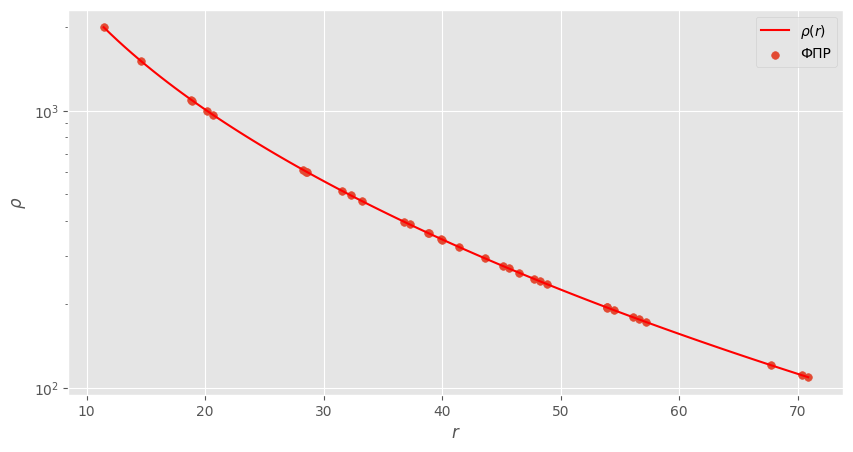

In [26]:
r_values = np.linspace(min(r), max(r), 100)
rho_values = rho_model(r_values, Ne, s)

r_opt = compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df)
rho_fit = rho_model(r_opt, Ne_opt, s_opt)

plt.figure(figsize=(10, 5))
plt.plot(r_values, rho_values, label=r'$\rho(r)$', color="red")
plt.scatter(r_opt, rho_fit, label="ФПР", s=30)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

Отгенеририм много событий

In [53]:
Z0 = -18
num_events = 1000

theta = np.round(np.random.uniform(0, 70, num_events), 1)
phi = np.round(np.random.uniform(190, 350, num_events), 1)
X0 = np.round(np.random.uniform(-50, 50, num_events), 1)
Y0 = np.round(np.random.uniform(-70, 70, num_events), 1)
Ne = np.round(np.random.uniform(1e5, 1e8, num_events), -3)
s = np.round(np.random.uniform(1.2, 1.5, num_events), 1)

In [54]:
data = pd.DataFrame({
    "theta": theta,
    "phi": phi,
    "X0": X0,
    "Y0": Y0,
    "Z0": Z0,
    "Ne": Ne,
    "s": s
})

data.head(3)

,theta,phi,X0,Y0,Z0,Ne,s
0,46.0,292.7,5.7,68.1,-18,22496000.0,1.4
1,55.2,245.2,-37.0,-53.4,-18,2120000.0,1.4
2,54.3,229.3,24.5,40.6,-18,16170000.0,1.4


In [55]:
def process_event(event, coordinates_df, bounds):
    r = compute_r(
        event['X0'], event['Y0'], event['Z0'], event['theta'], event['phi'], coordinates_df
    )
    rho = rho_model(r, event['Ne'], event['s'])
    result = differential_evolution(
        loss_function, bounds, args=(
            coordinates_df, rho, event['theta'], event['phi'], event['Z0'])
    )
    X0_opt, Y0_opt, Ne_opt, s_opt = result.x
    return r, rho, X0_opt, Y0_opt, Ne_opt, s_opt

In [56]:
def main(data, coordinates_df, bounds, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_event)(event, coordinates_df, bounds)
        for _, event in tqdm(data.iterrows(), total=len(data), desc='~')
    )

    r_values, rho_values, X0_opt_values, Y0_opt_values, Ne_opt_values, s_opt_values = zip(
        *results)

    return (
        list(r_values), list(rho_values), list(X0_opt_values),
        list(Y0_opt_values), list(Ne_opt_values), list(s_opt_values)
    )

In [58]:
r_values, rho_values, X0_opt_values, Y0_opt_values, Ne_opt_values, s_opt_values = main(
    data, coordinates_df, bounds)




















































































~: 100%|██████████| 1000/1000 [15:44<00:00,  1.06it/s]


In [59]:
X0_opt = np.array(X0_opt_values)
Y0_opt = np.array(Y0_opt_values)
Ne_opt = np.array(Ne_opt_values)
s_opt = np.array(s_opt_values)

In [61]:
X0_diff = X0_opt - X0
Y0_diff = Y0_opt - Y0
Ne_diff = (Ne_opt - Ne) / Ne
s_diff = s_opt - s

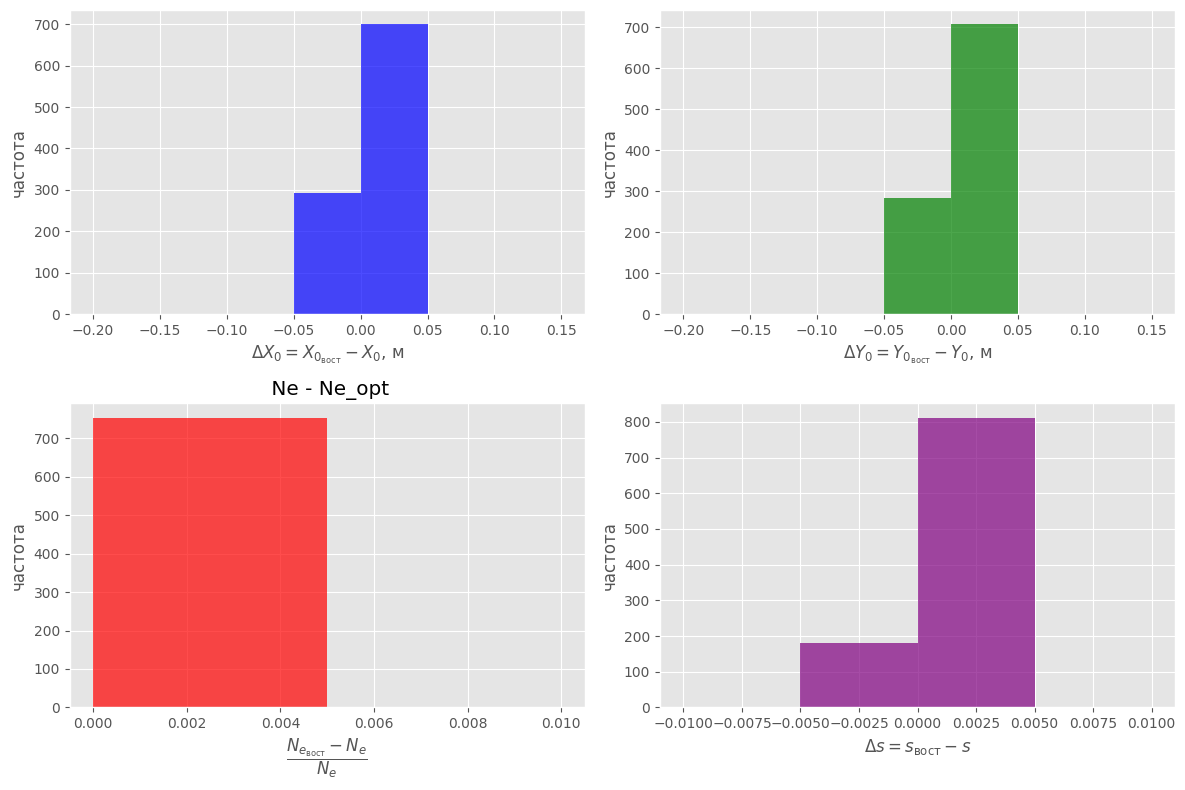

In [ ]:
interval_delta_r = 0.05
interval_delta_s = 0.005
interval_delta_Ne = 0.005

bin_edges_delta_r = np.arange(-0.2, 0.2, interval_delta_r)
bin_edges_delta_s = np.arange(-0.01, 0.011, interval_delta_s)
bin_edges_delta_Ne = np.arange(0, 0.015, interval_delta_Ne)

plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)

plt.hist(X0_diff, bins=bin_edges_delta_r, color='blue', alpha=0.7)

plt.xlabel(r'$\Delta X_0 = X_{0_{\text{вост}}} - X_{0}$, м')

plt.ylabel('частота')


plt.subplot(2, 2, 2)

plt.hist(Y0_diff, bins=bin_edges_delta_r, color='green', alpha=0.7)

plt.xlabel(r'$\Delta Y_0 = Y_{0_{\text{вост}}} - Y_{0}$, м')

plt.ylabel('частота')


plt.subplot(2, 2, 3)

plt.hist(Ne_diff, bins=bin_edges_delta_Ne, color='red', alpha=0.7)

plt.title(' Ne - Ne_opt')

plt.xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e}}{N_{e}}$')

plt.ylabel('частота')


plt.subplot(2, 2, 4)

plt.hist(s_diff, bins=bin_edges_delta_s, color='purple', alpha=0.7)

plt.xlabel(r'$\Delta s = s_{\text{вост}} - s$')

plt.ylabel('частота')


plt.tight_layout()

plt.show()